# Introduction to CMIP6 Data

**Coupled Model Intercomparison Project Phase 6 (CMIP6)** provides climate model outputs to assess global warming and associated impacts. In this lesson, we will explore the `tas` (2-m near-surface air temperature) variable, and look at its historical trends and future projections. Specifically, we will calculate when each cmip6 model (historical + ssp) reaches a given warming level

## What you'll learn:
1. How to access publicly available data (e.g., from NOAA) and load on AWS
2. How to load CMIP6 datasets publicly available on AWS using `intake`.
3. How to create annual mean, area-weighted, global-mean air temperature time series from observations and CMIP6 data
4. Calculate when each CMIP6 model (in the historical and ssp585 experiments) reaches various global warming thresholds

In [1]:
# import packages needed for loading data, etc.
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib

import requests
from bs4 import BeautifulSoup
import intake

import warnings
warnings.filterwarnings("ignore")

## let's first download a dataset from NOAA of global near-surface air temperatures to look at what the observations have to say about global temperature changes related to the pre-industrial time period (1850-1899)


In [2]:
# URL of the directory where NOAA Global Surface Temperature data is hosted
base_url = "https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/gridded/"

# Step 1: Scrape the webpage to find the NetCDF file link
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

# Find all links that end with '.nc'
nc_file = None
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.nc'):
        nc_file = href
        break

if nc_file:
    print(f"Found NetCDF file: {nc_file}")
    
    # Full URL to the NetCDF file
    nc_url = base_url + nc_file
    
    # Step 2: Download the NetCDF file
    filename = nc_file.split('/')[-1]
    print(f"Downloading file: {filename}")
    
    # Download the file
    nc_response = requests.get(nc_url)
    with open(filename, 'wb') as f:
        f.write(nc_response.content)

    print(f"File saved as {filename}")

    # Step 3: Load the file using xarray
    ds = xr.open_dataset(filename)

else:
    print("No NetCDF file found in the directory.")


Found NetCDF file: NOAAGlobalTemp_v6.0.0_gridded_s185001_e202408_c20240908T153507.nc
File saved as NOAAGlobalTemp_v6.0.0_gridded_s185001_e202408_c20240908T153507.nc


## let's look at the noaa dataset and calculate global-mean temperatures

In [3]:
ds

<xarray.Dataset> Size: 22MB
Dimensions:  (time: 2096, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2024-08-01
  * lat      (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 288B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 4B 0.0
Data variables:
    anom     (time, z, lat, lon) float32 22MB ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P174Y8M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2024-09-08T19:35:12Z
    date_issued:                     2024-09-08T19:35:12Z

## let's plot one time step to look at the data
### note the globe is stretched onto a regularly spaced latitude/longitude grid

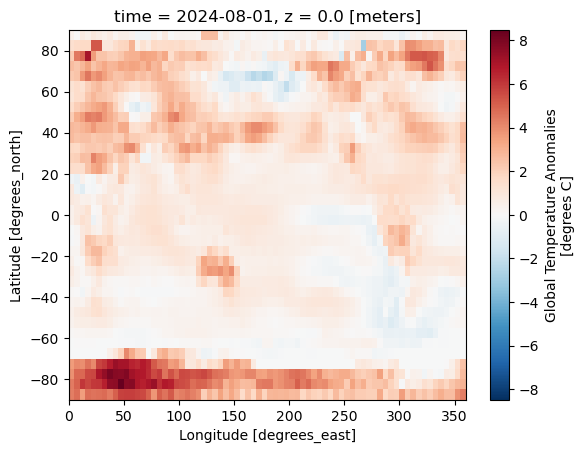

In [4]:
ds['anom'].sel(time='2024-08-01').plot()

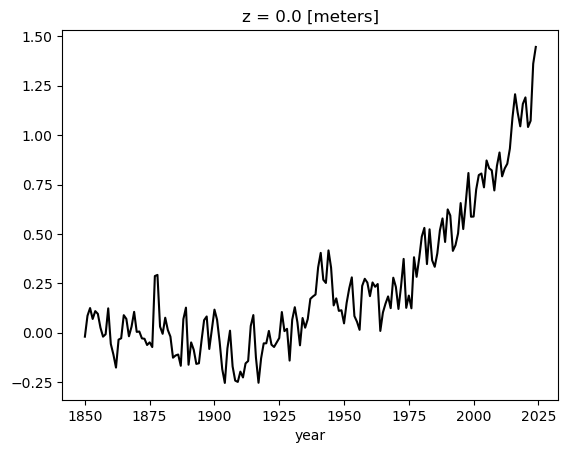

In [5]:
# pull the variable 'anom' out of the dataset
da = ds['anom']
# group monthly data into annual-mean time series
da_ann = da.groupby('time.year').mean('time')
#weight for global mean
w = np.cos(np.deg2rad(da_ann.lat)) #we are going to area-weight by the cosine of the latitude (as we approach poles, data more and more stretched onto grid)
w = w.broadcast_like(da_ann) #broadcast the weighting across all longitudes and time
#we can have some missing data, so let's pull out and area-weight the temperature anomalies where no missing data
gmt2m = (w.where(da_ann.notnull()) * da_ann).sum(dim=('lon','lat')) / w.where(da_ann.notnull()).sum(dim=('lon','lat'))
#we want to examine how much temperature has changed since the pre-industrial, so let's calculate anomalies from this time period
gmt2m_anom_noaa = (gmt2m - gmt2m.sel(year=slice(1850,1899)).mean(dim='year')).sel(year=slice(1850,2099))
# plot time series
gmt2m_anom_noaa.plot(color='black')

## now let's load the climate model (cmip6) data

In [6]:
# Define where catalog is
catalog_url = "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"  # CMIP6 catalog URL on AWS
col = intake.open_esm_datastore(catalog_url)  # Open the CMIP6 catalog using Intake-ESM

#pick which ssp we want to load below
#we are going with ssp585 because it's a high-emissions pathway and we want to examine impacts at warming levels including 3C
#under a lower emissions pathway, like ssp245, some climate models may not reach 3C before 2100
ssp = 'ssp585' 

# Define our query for filtering the data
query = dict(
    variable_id=["tas"],  # Select surface air temperature
    experiment_id=["historical", ssp],  # Select historical and future ssp (e.g., ssp245, ssp585)
    table_id=["Amon"],  # Monthly atmospheric data
    member_id = ["r1i1p1f1"],)  # Specific ensemble member
    #source_id=["ACCESS-CM2"])  # Specify the model

col_subset = col.search(**query)  # Search and filter the catalog based on the query

# Group and display relevant columns to inspect results
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]]

col_subset = col_subset.search(require_all_on=["source_id"], **query)  # Further refine the search to ensure all criteria match
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]]  # Re-check the filtered results


In [7]:
# Filter to only include historical data for the "tas" variable
col_subset_historical = col_subset.search(variable_id=["tas"], experiment_id=["historical"])
col_subset_historical.df.sort_values("source_id")  # Sort the results by source_id

col_subset_ssp = col_subset.search(variable_id=["tas"],experiment_id=[ssp])
col_subset_ssp.df.sort_values("source_id")

datasets_historical = col_subset_historical.to_dataset_dict(cdf_kwargs={})  # Convert the filtered results into xarray datasets
datasets_ssp = col_subset_ssp.to_dataset_dict(cdf_kwargs={})

#uncomment next line to display the dataframe
#col_subset_historical.df



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## loop through and load each climate model

In [8]:
%%time 
#time how long it takes to loop through all CMIP6 models defined above

#empty list to be filled with each model name
cmip6_models = []

for hii, hi in enumerate(datasets_historical):  # Loop through historical datasets, hii is the index, hi is the dataset key
    
    ds_historical = datasets_historical[hi]  # Get the historical dataset for the current model
    
    for sii, si in enumerate(datasets_ssp):  # Nested loop through ssp datasets, sii is the index, si is the dataset key
        
        ds_ssp = datasets_ssp[si]  # Get the ssp dataset for the current model
        
        if ds_ssp.attrs['source_id'] == ds_historical.attrs['source_id']:  # Match datasets by model (source_id)
            
            print('loading data for both experiments from:', ds_ssp.attrs['source_id'])  # Inform which model is being processed

            #append this model's name to list
            cmip6_models.append(ds_ssp.attrs['source_id'])
            
            # Convert historical 'tas' (temperature) from Kelvin to Celsius
            da_historical = (ds_historical['tas'] - 273.15)
            
            # Calculate the annual mean temperature for historical data (1850-2014)
            da_historical_ann = da_historical.groupby('time.year').mean('time').sel(year=slice(1850, 2014))
            
            # Convert ssp 'tas' (temperature) from Kelvin to Celsius
            da_ssp = ds_ssp['tas'] - 273.15
            
            # Calculate the annual mean temperature for ssp data (2015-2100)
            da_ssp_ann = da_ssp.groupby('time.year').mean('time').sel(year=slice(2015, 2100))

            # Concatenate the historical and ssp data along the 'year' dimension
            da_historical_ssp_ann = xr.concat((da_historical_ann, da_ssp_ann), dim='year')
            
            # Calculate weights based on latitude for global mean (cosine latitude weighting)
            w = np.cos(np.deg2rad(da_historical_ssp_ann.lat))
            w = w.broadcast_like(da_historical_ssp_ann)  # Ensure weights have the same shape as the data
            
            # Calculate global mean temperature using area weights (latitude weighted average)
            gmt2m = ((w * da_historical_ssp_ann).sum(dim=('lon', 'lat')) / w.sum(dim=('lon', 'lat'))).compute()
            
            if hii == 0:  # For the first iteration, initialize the global mean temperature (gmt) collection
                cmip6_gmtm = gmt2m
            else:
                # For subsequent iterations, concatenate the global mean temperature data along the 'model' dimension
                cmip6_gmtm = xr.concat((cmip6_gmtm, gmt2m), dim='model')


loading data for both experiments from: CAMS-CSM1-0
loading data for both experiments from: EC-Earth3-Veg
loading data for both experiments from: AWI-CM-1-1-MR
loading data for both experiments from: MPI-ESM1-2-HR
loading data for both experiments from: CMCC-ESM2
loading data for both experiments from: KACE-1-0-G
loading data for both experiments from: NorESM2-LM
loading data for both experiments from: INM-CM4-8
loading data for both experiments from: EC-Earth3
loading data for both experiments from: TaiESM1
loading data for both experiments from: CESM2-WACCM
loading data for both experiments from: FGOALS-g3
loading data for both experiments from: FGOALS-f3-L
loading data for both experiments from: MRI-ESM2-0
loading data for both experiments from: GFDL-CM4
loading data for both experiments from: KIOST-ESM
loading data for both experiments from: E3SM-1-1
loading data for both experiments from: GFDL-ESM4
loading data for both experiments from: IPSL-CM6A-LR
loading data for both experime

## compute anomalies (changes) from pre-industrial time period

In [9]:
cmip6_gmtm_anom = (
    cmip6_gmtm 
    - cmip6_gmtm.sel(year=slice(1850,1899)).mean(dim='year')
).sel(year=slice(1850,2100)).compute()  # Calculate temperature anomalies relative to the 1850-1899 mean, select data for 1850-2100, and compute

cmip6_gmtm_anom = cmip6_gmtm_anom.squeeze()  # Remove any singleton dimensions from the data (e.g., a dimension of size 1)


## take a quick look at the data in a plot

Text(0.5, 1.0, 'CMIP6 hist+ssp585 NOAA GlobalTemp Global-Mean tas anomalies')

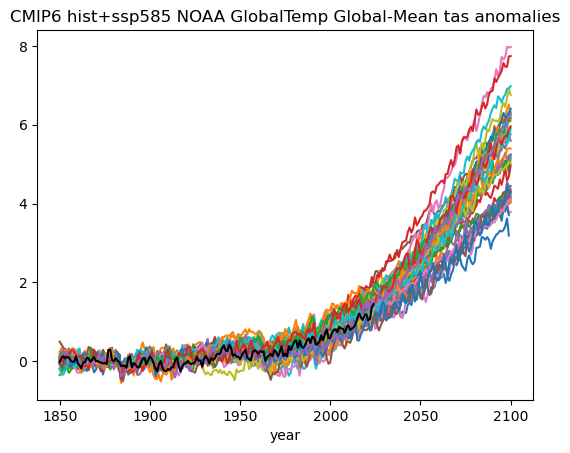

In [10]:
for mi,model in enumerate(cmip6_models):
    cmip6_gmtm_anom.sel(model=mi).plot()
gmt2m_anom_noaa.plot(color='black')
plt.title('CMIP6 hist+'+str(ssp)+' NOAA GlobalTemp Global-Mean tas anomalies')

## calculate when global-mean temperature anomalies cross temperature thresholds in annual and 20-year smoothed data

In [11]:
rolling_ave_window = 20  # Set the window size for the rolling average (20 years)
temps = [1, 1.5, 2, 2.5, 3]  # List of temperature thresholds (in degrees Celsius) to analyze

for ti, temp in enumerate(temps):  # Loop through each temperature threshold
    
    print('assessing when each climate model reaches',temp,'C Global Warming Threshold')
    
    # Initialize empty lists for storing years when temperature thresholds are reached
    vars()['firstyear_' + str(temp) + 'C'] = []
    vars()['firstyear_rolling_' + str(temp) + 'C'] = []
    
    for mi, model in enumerate(cmip6_models):  # Loop through each model in the ssp dataset
        
        # Select annual data for the current model
        annual = cmip6_gmtm_anom.sel(model=mi)
        
        # Find the first year where the temperature anomaly reaches the threshold (e.g., 1.5°C)
        year_temp = (annual.year.where(annual >= temp, drop=True)).year.min().item()
        vars()['firstyear_' + str(temp) + 'C'].append(year_temp)
        
        # Calculate the rolling average (20-year window) for annual data
        smoothed = annual.rolling(year=rolling_ave_window, center=True).mean()
        
        # Find the first year where the rolling mean matches the temperature threshold
        year_temp_smoothed = (smoothed.year.where(smoothed >= temp, drop=True)).year.min().item()
        vars()['firstyear_rolling_' + str(temp) + 'C'].append(year_temp_smoothed)  # Append to the rolling average list
        

assessing when each climate model reaches 1 C Global Warming Threshold
assessing when each climate model reaches 1.5 C Global Warming Threshold
assessing when each climate model reaches 2 C Global Warming Threshold
assessing when each climate model reaches 2.5 C Global Warming Threshold
assessing when each climate model reaches 3 C Global Warming Threshold


## save when each model crosses the global warming threshold

In [18]:
all_temps_annual = np.vstack((np.array(vars()['firstyear_'+str(1)+'C']),
                       np.array(vars()['firstyear_'+str(1.5)+'C']),
                       np.array(vars()['firstyear_'+str(2)+'C']),
                       np.array(vars()['firstyear_'+str(2.5)+'C']),
                       np.array(vars()['firstyear_'+str(3)+'C']),
                      )
                     ).T

cmip6_models_warminglevels_df_annual = pd.DataFrame(data=(all_temps_annual),
             index=cmip6_models,
            columns=temps)  # 1st row as the column names

#rename index column
cmip6_models_warminglevels_df_annual.index.name = 'CMIP6 Model'

#sort by index column CMIP6 Model
cmip6_models_warminglevels_df_annual = cmip6_models_warminglevels_df_annual.sort_index()

#save as a csv file
cmip6_models_warminglevels_df_annual.to_csv('CMIP6_nModels_'+str(len(cmip6_models))+'_GWLevels_'+str(ssp)+'_ANNUAL_UNSMOOTHED_FirstYearCrossThreshold.csv')

,1.0,1.5,2.0,2.5,3.0
CMIP6 Model,,,,,
ACCESS-CM2,2012,2021,2037,2049,2056
ACCESS-ESM1-5,2013,2026,2039,2052,2060
AWI-CM-1-1-MR,2000,2017,2030,2049,2058
BCC-CSM2-MR,2018,2032,2044,2057,2065
CAMS-CSM1-0,2022,2037,2059,2069,2084
CAS-ESM2-0,2017,2030,2043,2051,2059
CESM2-WACCM,2001,2021,2034,2042,2053
CIESM,1990,2016,2030,2039,2051
CMCC-CM2-SR5,2001,2016,2036,2041,2048


In [19]:
all_temps_rolling = np.vstack((
    np.array(vars()['firstyear_rolling_'+str(1)+'C']),
    np.array(vars()['firstyear_rolling_'+str(1.5)+'C']),
    np.array(vars()['firstyear_rolling_'+str(2)+'C']),
    np.array(vars()['firstyear_rolling_'+str(2.5)+'C']),
    np.array(vars()['firstyear_rolling_'+str(3)+'C']),
                      )
                     ).T

cmip6_models_warminglevels_df_rolling = pd.DataFrame(data=(all_temps_rolling),
             index=cmip6_models,
            columns=temps)  # 1st row as the column names

cmip6_models_warminglevels_df_rolling.index.name = 'CMIP6 Model'

cmip6_models_warminglevels_df_rolling = cmip6_models_warminglevels_df_rolling.sort_index()

cmip6_models_warminglevels_df_rolling.to_csv('CMIP6_nModels_'+str(len(cmip6_models))+'_GWLevels_'+str(ssp)+'_Smoothed_FirstYearThreshold.csv')

## print when reach 2C global warming in this ssp, and then make a histogram using both 

Annual method median: 2037.0
Annual method 5th percentile: 2023.7
Annual method 95th percentile: 2052.9

Rolling method median: 2039.0
Rolling method 5th percentile: 2026.8
Rolling method 95th percentile: 2055.6


Text(0, 0.5, 'Number of Models')

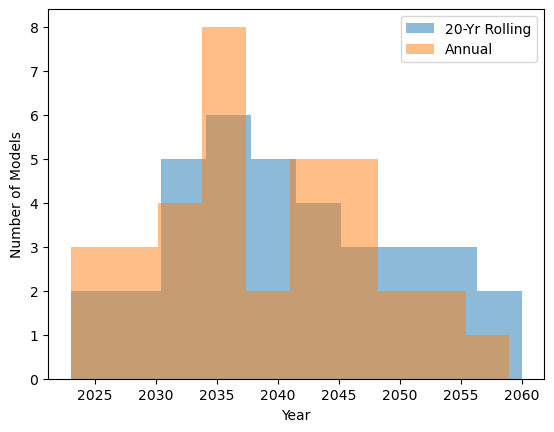

In [14]:
temp = 2

print('Annual method median:',np.median(np.array(vars()['firstyear_'+str(temp)+'C'])))
print('Annual method 5th percentile:',np.quantile(np.array(vars()['firstyear_'+str(temp)+'C']),0.05))
print('Annual method 95th percentile:',np.quantile(np.array(vars()['firstyear_'+str(temp)+'C']),0.95))
print('')

print('Rolling method median:',np.median(np.array(vars()['firstyear_rolling_'+str(temp)+'C'])))
print('Rolling method 5th percentile:',np.quantile(np.array(vars()['firstyear_rolling_'+str(temp)+'C']),0.05))
print('Rolling method 95th percentile:',np.quantile(np.array(vars()['firstyear_rolling_'+str(temp)+'C']),0.95))

plt.hist(np.array(vars()['firstyear_rolling_'+str(temp)+'C']),alpha=0.5,label='20-Yr Rolling')
plt.hist(np.array(vars()['firstyear_'+str(temp)+'C']),alpha=0.5,label='Annual')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Models')

## make line graph of gmtas, and plot dots when each climate model reaches a given warming level

In [ ]:
time = cmip6_gmtm_anom.year

fsize = 14

fig = plt.figure(figsize=(8,6)) #set figure size

ax = plt.subplot(1,1,1)

plt.fill_between(time,
                 cmip6_gmtm_anom.rolling(year=rolling_ave_window, center=True).mean().max(dim='model'),
                 cmip6_gmtm_anom.rolling(year=rolling_ave_window, center=True).mean().min(dim='model'),
                 color='darkred',
                alpha=0.5)
plt.plot(time,
         cmip6_gmtm_anom.rolling(year=rolling_ave_window, center=True).mean().median(dim='model'),
         color='darkred',
        label='Historical + '+str(ssp))

for ti,temp in enumerate(temps):
    for mi,model in enumerate(cmip6_models):
        plt.scatter(vars()['firstyear_rolling_'+str(temp)+'C'][mi],temp)

gmt2m_anom_noaa.plot(color='black',label='NOAA GlobalTemp')

plt.xlim(1850,2099)
plt.ylim(-0.5,5.5)
plt.grid()
plt.axhline(0, color='black', linestyle=':',linewidth=2,label=('1850-1899 Average'))
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.ylabel('Global-Mean Temperature Change ($^o$C)',fontsize=fsize)
plt.legend(loc='upper left',fontsize=fsize)
plt.title('CMIP6 Global-Mean Temperature Change \n Relative to 19th Century (Rolling 20yr Ave, '+str(ssp)+')',fontsize=fsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
